# Q1. What is the price distribution of menu items?

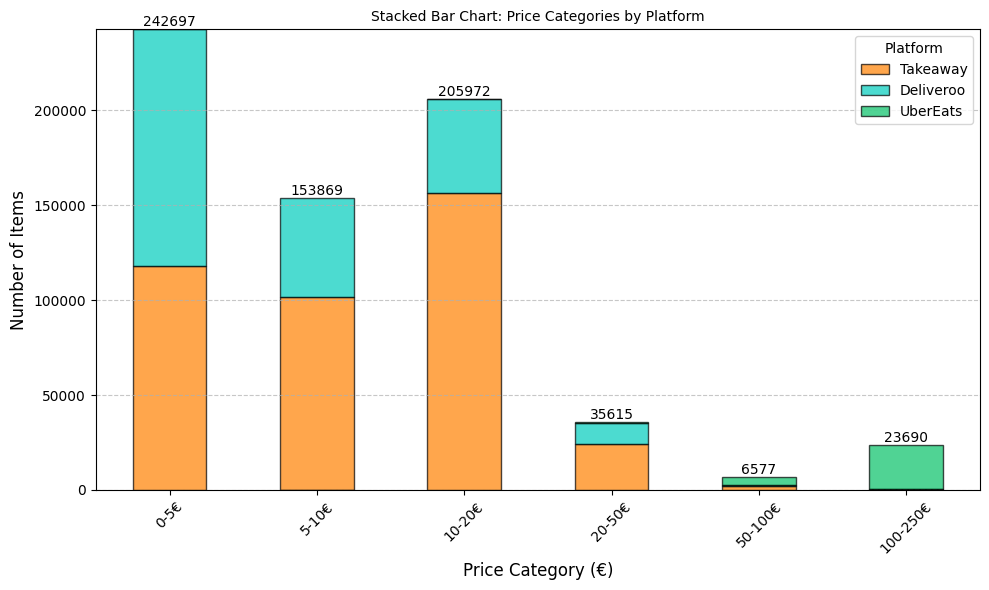

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# database paths 
databases = {
    "Takeaway":  r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db",
    "Deliveroo": r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db",
    "UberEats":  r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db",
}

def fetch_prices(db_path, table_name="menuItems", price_column="price"):
    # Fetch prices as floats from a specific table/column
    try:
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()
            query = f"""
                SELECT {price_column}
                FROM {table_name}
                WHERE {price_column} IS NOT NULL
                  AND TRIM({price_column}) <> ''
                  AND CAST({price_column} AS REAL) > 0;
            """
            cursor.execute(query)
            prices = [float(row[0]) for row in cursor.fetchall()]
        return prices
    except Exception as e:
        print(f"Error fetching data from {db_path}: {e}")
        return []

# Fetch prices for each platform 
filtered_takeaway_prices  = fetch_prices(databases["Takeaway"],  "menuItems",  "price")
filtered_deliveroo_prices = fetch_prices(databases["Deliveroo"], "menu_items", "price")
filtered_ubereats_prices  = fetch_prices(databases["UberEats"],  "menu_items", "price")

# Define price bins
bins = [0, 5, 10, 20, 50, 100, 250]
labels = ['0-5€', '5-10€', '10-20€', '20-50€', '50-100€', '100-250€']

# Bin prices
takeaway_binned  = pd.cut(filtered_takeaway_prices,  bins=bins, labels=labels, right=False)
deliveroo_binned = pd.cut(filtered_deliveroo_prices, bins=bins, labels=labels, right=False)
ubereats_binned  = pd.cut(filtered_ubereats_prices,  bins=bins, labels=labels, right=False)

# Count bins 
takeaway_counts  = takeaway_binned.value_counts().reindex(labels, fill_value=0)
deliveroo_counts = deliveroo_binned.value_counts().reindex(labels, fill_value=0)
ubereats_counts  = ubereats_binned.value_counts().reindex(labels, fill_value=0)

# Combine into one DataFrame
bar_data = pd.DataFrame({
    "Price Category": labels,
    "Takeaway": takeaway_counts.values,
    "Deliveroo": deliveroo_counts.values,
    "UberEats": ubereats_counts.values
})

# Plot stacked bars 
ax = bar_data.set_index("Price Category").plot(
    kind="bar",
    stacked=True,
    color=["#FF8000", "#00CCBC", "#06C167"],  # Takeaway, Deliveroo, UberEats
    edgecolor="black",
    alpha=0.7,
    figsize=(10, 6),
)
ax.set_title("Stacked Bar Chart: Price Categories by Platform", fontsize=10)
ax.set_xlabel("Price Category (€)", fontsize=12)
ax.set_ylabel("Number of Items", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
ax.legend(title="Platform", fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Add totals on top of each stacked bar
totals = bar_data[["Takeaway", "Deliveroo", "UberEats"]].sum(axis=1).values
for i, total in enumerate(totals):
    ax.text(i, total, str(int(total)), ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


# Q2.  What is the distribution of restaurants per location?

In [75]:
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Restaurants per location (Takeaway)
df_ta = q(conn, """
SELECT
  l.ID AS location_id,
  l.city,
  l.postalCode,
  l.latitude,
  l.longitude,
  COUNT(DISTINCT lr.restaurant_id) AS restaurants
FROM ta.locations l
JOIN ta.locations_to_restaurants lr
  ON lr.location_id = l.ID
WHERE l.latitude IS NOT NULL AND l.longitude IS NOT NULL
GROUP BY l.ID, l.city, l.postalCode, l.latitude, l.longitude;
""")

# HeatMap expects [lat, lon, weight]
heat_data = df_ta[["latitude", "longitude", "restaurants"]].values.tolist()

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)
HeatMap(heat_data, radius=18, blur=15, min_opacity=0.3).add_to(m)

out_path = Path(r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\heatmap_takeaway_restaurants_per_location.html").resolve()
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\heatmap_takeaway_restaurants_per_location.html


# All platforms heat map of restuarant location

In [91]:

TAKEAWAY_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db"
UBEREATS_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db"
DELIVEROO_DB = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db"

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

conn = sqlite3.connect(DELIVEROO_DB)
conn.execute(f"ATTACH DATABASE '{TAKEAWAY_DB}' AS ta;")
conn.execute(f"ATTACH DATABASE '{UBEREATS_DB}' AS ue;")

df_del = q(conn, """
SELECT latitude, longitude
FROM restaurants
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

df_ta = q(conn, """
SELECT
  l.latitude,
  l.longitude,
  COUNT(DISTINCT lr.restaurant_id) AS restaurants
FROM ta.locations l
JOIN ta.locations_to_restaurants lr ON lr.location_id = l.ID
WHERE l.latitude IS NOT NULL AND l.longitude IS NOT NULL
GROUP BY l.latitude, l.longitude;
""")

df_ue = q(conn, """
SELECT latitude, longitude
FROM ue.locations
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

# Different color gradients per platform
grad_deliveroo = {0.2: "#b2f5ea", 0.5: "#00ccbc", 0.8: "#006d66"}  # teal
grad_takeaway  = {0.2: "#ffe0b2", 0.5: "#ff8000", 0.8: "#8a3d00"}  # orange
grad_ubereats  = {0.2: "#c8f7d0", 0.5: "#06c167", 0.8: "#014d2a"}  # green

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

fg_del = folium.FeatureGroup(name="Deliveroo (restaurants)", show=True)
HeatMap(
    df_del[["latitude", "longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_deliveroo
).add_to(fg_del)
fg_del.add_to(m)

fg_ta = folium.FeatureGroup(name="Takeaway (restaurants per location)", show=False)
HeatMap(
    df_ta[["latitude", "longitude", "restaurants"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_takeaway
).add_to(fg_ta)
fg_ta.add_to(m)

fg_ue = folium.FeatureGroup(name="UberEats (locations)", show=False)
HeatMap(
    df_ue[["latitude", "longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_ubereats
).add_to(fg_ue)
fg_ue.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

out_path = Path(r"C:\Users\welde\Desktop\heatmap_toggle_all_platforms.html")
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\heatmap_toggle_all_platforms.html


# Q6. Where are the delivery ‘dead zones’ minimal restaurant coverage areas?

In [76]:
import geopandas as gpd
FLANDERS_GEO_PATH = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\georef-belgium.geojson"
regions = gpd.read_file(FLANDERS_GEO_PATH)

# Find rows that look like Flanders (robust search across text columns)
text_cols = [c for c in regions.columns if regions[c].dtype == "object"]
mask = False
for c in text_cols:
    mask = mask | regions[c].astype(str).str.contains("Fland|Vlaam|Vlaanderen", case=False, na=False)

flanders = regions[mask].dissolve()  # merge into one polygon/multipolygon
flanders = flanders.to_crs("EPSG:4326")

# Convert points to GeoDataFrame and keep only those inside Flanders
pts = gpd.GeoDataFrame(
    points,
    geometry=gpd.points_from_xy(points["longitude"], points["latitude"]),
    crs="EPSG:4326"
)
pts_flanders = gpd.sjoin(pts, flanders, predicate="within", how="inner").drop(columns=["index_right"])

pts_flanders.head()


latitude longitude   platform                  geometry  \
11  51.229771  4.404195  deliveroo  POINT (4.40419 51.22977)   
12  51.223626  4.403362  deliveroo  POINT (4.40336 51.22363)   
13  51.220933  4.400281  deliveroo  POINT (4.40028 51.22093)   
14  51.210486  4.396962  deliveroo  POINT (4.39696 51.21049)   
15  51.215468  4.409274  deliveroo  POINT (4.40927 51.21547)   

                                         geo_point_2d geo_shape postcode  \
11  {'lon': 4.8924806024977405, 'lat': 50.87243034...      None     3211   
12  {'lon': 4.8924806024977405, 'lat': 50.87243034...      None     3211   
13  {'lon': 4.8924806024977405, 'lat': 50.87243034...      None     3211   
14  {'lon': 4.8924806024977405, 'lat': 50.87243034...      None     3211   
15  {'lon': 4.8924806024977405, 'lat': 50.87243034...      None     3211   

    special_code smun_code reg_code  ...      reg_name_fr prov_name_de  \
11             0    24066B    02000  ...  Région flamande         None   
12             0    24066B    02000  ...  Région flamande         None   
13             0    24066B    02000  ...  Région flamande         None   
14             0    24066B    02000  ...  Région flamande         None   
15             0    24066B    02000  ...  Région flamande         None   

      prov_name_nl          prov_name_fr arr_name_de arr_name_nl  \
11  Vlaams-Brabant  Brabant flamand (le)        None      Leuven   
12  Vlaams-Brabant  Brabant flamand (le)        None      Leuven   
13  Vlaams-Brabant  Brabant flamand (le)        None      Leuven   
14  Vlaams-Brabant  Brabant flamand (le)        None      Leuven   
15  Vlaams-Brabant  Brabant flamand (le)        None      Leuven   

     arr_name_fr mun_name_de mun_name_nl mun_name_fr  
11  Hal-Vilvorde        None     Lubbeek     Fourons  
12  Hal-Vilvorde        None     Lubbeek     Fourons  
13  Hal-Vilvorde        None     Lubbeek     Fourons  
14  Hal-Vilvorde        None     Lubbeek     Fourons  
15  Hal-Vilvorde        None     Lubbeek     Fourons  

[5 rows x 30 columns]

In [78]:

import numpy as np
import geopandas as gpd
from shapely.geometry import box
import folium
from folium.plugins import HeatMap
from pathlib import Path

# -----------------------------
# SETTINGS 
# -----------------------------
CELL_SIZE_M = 3000   # grid size: 5000m = 5 km 
THRESHOLD   = 2      # dead zone if a cell has <= 2 restaurants (all platforms combined)

# Where to save the HTML map
out_path = Path(r"C:\Users\welde\Desktop\dead_zones_flanders.html")

# Heatmap colors (optional layers)
grad_deliveroo = {0.2: "#b2f5ea", 0.5: "#00ccbc", 0.8: "#006d66"}
grad_takeaway  = {0.2: "#ffe0b2", 0.5: "#ff8000", 0.8: "#8a3d00"}
grad_ubereats  = {0.2: "#c8f7d0", 0.5: "#06c167", 0.8: "#014d2a"}

# -----------------------------
# Combine all restaurant points
# -----------------------------
df_del2 = df_del[["latitude","longitude"]].dropna().copy()
df_del2["platform"] = "deliveroo"

df_ta2 = df_ta[["latitude","longitude"]].dropna().copy()
df_ta2["platform"] = "takeaway"

df_ue2 = df_ue[["latitude","longitude"]].dropna().copy()
df_ue2["platform"] = "ubereats"

points = pd.concat([df_del2, df_ta2, df_ue2], ignore_index=True)

# -----------------------------
# Keep only points inside Flanders
# -----------------------------
pts = gpd.GeoDataFrame(
    points,
    geometry=gpd.points_from_xy(points["longitude"], points["latitude"]),
    crs="EPSG:4326"
)

# spatial join: keep points that fall inside the Flanders polygon
pts_flanders = gpd.sjoin(pts, flanders_wgs, predicate="within", how="inner").drop(columns=["index_right"])
pts_flanders_df = pd.DataFrame(pts_flanders.drop(columns="geometry"))

# -----------------------------
# Make a grid (in meters) and count restaurants per grid cell
# -----------------------------
# Convert to a meter-based CRS for correct distances
flanders_m = flanders_wgs.to_crs(31370)      # Belgian Lambert 72 (meters)
pts_m = pts_flanders.to_crs(31370)

# Create a square grid covering Flanders
minx, miny, maxx, maxy = flanders_m.total_bounds
xs = np.arange(minx, maxx, CELL_SIZE_M)
ys = np.arange(miny, maxy, CELL_SIZE_M)

cells = []
cell_id = 0
for x in xs:
    for y in ys:
        cells.append((cell_id, box(x, y, x + CELL_SIZE_M, y + CELL_SIZE_M)))
        cell_id += 1

grid = gpd.GeoDataFrame(cells, columns=["cell_id","geometry"], crs=31370)

# Keep only cells that intersect Flanders 
grid = gpd.overlay(grid, flanders_m, how="intersection")

# Count how many points fall into each grid cell
joined = gpd.sjoin(pts_m[["geometry"]], grid[["cell_id","geometry"]], predicate="within", how="left")
counts = joined.groupby("cell_id").size().reset_index(name="n_restaurants")

grid = grid.merge(counts, on="cell_id", how="left")
grid["n_restaurants"] = grid["n_restaurants"].fillna(0).astype(int)

# Dead zones = low coverage cells
dead = grid[grid["n_restaurants"] <= THRESHOLD].copy()

# -----------------------------
#  Build the folium map
# -----------------------------
dead_wgs = dead.to_crs("EPSG:4326")
flanders_outline = flanders_m.to_crs("EPSG:4326")

m = folium.Map(location=[50.95, 4.5], zoom_start=8)

# Flanders outline
folium.GeoJson(
    flanders_outline.__geo_interface__,
    name="Flanders boundary",
    style_function=lambda x: {"color": "black", "weight": 2, "fillOpacity": 0}
).add_to(m)

# Dead zones layer
folium.GeoJson(
    dead_wgs.__geo_interface__,
    name=f"Dead zones (<= {THRESHOLD} restaurants per {CELL_SIZE_M/1000:.0f}km cell)",
    style_function=lambda x: {"color": "red", "weight": 1, "fillColor": "red", "fillOpacity": 0.25},
    tooltip=folium.GeoJsonTooltip(fields=["n_restaurants"], aliases=["Restaurants in cell:"])
).add_to(m)

# Optional heatmaps per platform (toggle layers)
fg_del = folium.FeatureGroup(name="Deliveroo (restaurants)", show=False)
HeatMap(
    pts_flanders_df.query("platform=='deliveroo'")[["latitude","longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3, gradient=grad_deliveroo
).add_to(fg_del)
fg_del.add_to(m)

fg_ta = folium.FeatureGroup(name="Takeaway (restaurants)", show=False)
HeatMap(
    pts_flanders_df.query("platform=='takeaway'")[["latitude","longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3, gradient=grad_takeaway
).add_to(fg_ta)
fg_ta.add_to(m)

fg_ue = folium.FeatureGroup(name="UberEats (restaurants)", show=False)
HeatMap(
    pts_flanders_df.query("platform=='ubereats'")[["latitude","longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3, gradient=grad_ubereats
).add_to(fg_ue)
fg_ue.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# Save + show
m.save(str(out_path))
print("Saved to:", out_path)
print(f"Points in Flanders: {len(pts_flanders_df):,} | Dead cells: {len(dead):,}")

m


Saved to: C:\Users\welde\Desktop\dead_zones_flanders.html
Points in Flanders: 5,384 | Dead cells: 1,239


# Q3. Which are the top 10 pizza restaurants by rating?

In [66]:
top_pizza_sql = """
SELECT DISTINCT
  r.primarySlug,
  r.name,
  CAST(r.ratings AS REAL) AS ratings,
  CAST(r.ratingsNumber AS INT) AS ratingsNumber
FROM ta.restaurants r
JOIN ta.categories_restaurants cr
  ON cr.restaurant_id = r.primarySlug
WHERE LOWER(cr.category_id) LIKE '%pizza%'
  AND CAST(r.ratingsNumber AS INT) > 100
ORDER BY ratings DESC
LIMIT 10;
"""
top_pizza = q(conn, top_pizza_sql)
top_pizza


primarySlug                        name  ratings  \
0                   veziroglu                   Veziroglu      5.0   
1        trend-kebab-pizzeria      Trend Kebab & Pizzeria      5.0   
2         kebap-pizza-de-brug       Kebap - Pizza De Brug      5.0   
3     eethuis-carlos-aarschot     De Echte Eethuis Carlos      5.0   
4                am-princesse                Am Princesse      4.9   
5  pizzeria-zirar-saint-denis  Pizzeria Zirar Saint-Denis      4.9   
6                  snack-emes        Snack Pizzeria Izmir      4.9   
7                de-notenboom                De Notenboom      4.9   
8                 pizza-lesta                Pizza L'Esta      4.9   
9  pitza-service-sint-niklaas               Pitza Service      4.9   

   ratingsNumber  
0            455  
1            165  
2            312  
3            599  
4            367  
5            529  
6            498  
7            706  
8            372  
9           1315

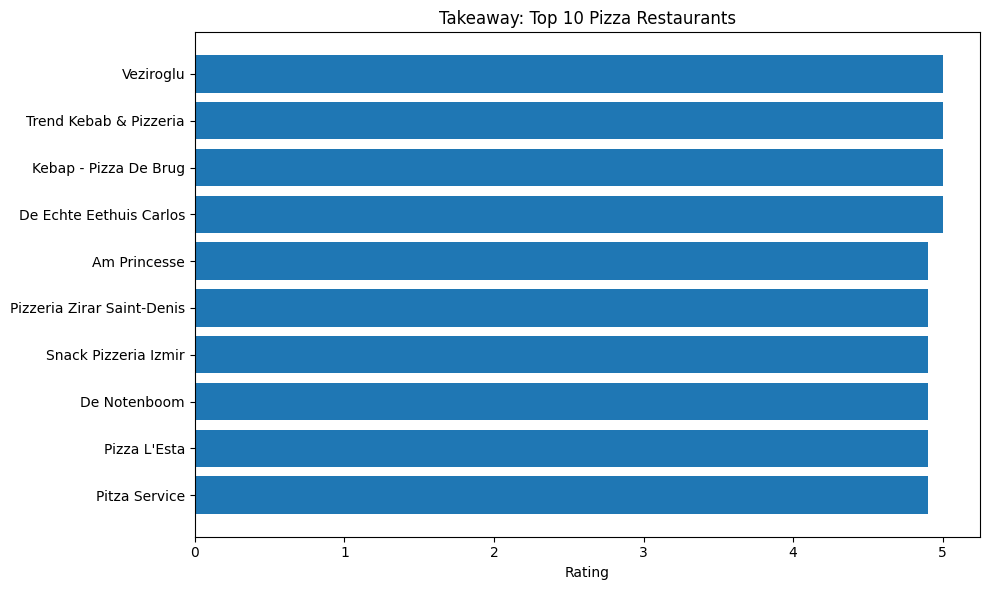

In [67]:

import matplotlib.pyplot as plt

df = top_pizza.copy()

# Keep only valid ratings, sort best to worst, take top 10
df = df.dropna(subset=["ratings"])
df = df.sort_values("ratings", ascending=False).head(10)

df["label"] = df["name"].astype(str)

plt.figure(figsize=(10, 6))
plt.barh(df["label"], df["ratings"])
plt.title("Takeaway: Top 10 Pizza Restaurants")
plt.xlabel("Rating")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()





# Map locations offering kapsalons and their average price

In [83]:

kapsalon_sql = """
SELECT
  r.name AS name,
  CAST(r.latitude AS REAL)  AS latitude,
  CAST(r.longitude AS REAL) AS longitude,
  r.address AS address,
  ROUND(AVG(CAST(mi.price AS REAL)), 2) AS avg_price
FROM ta.restaurants r
JOIN ta.menuItems mi
  ON mi.primarySlug = r.primarySlug
WHERE mi.name IS NOT NULL
  AND LOWER(mi.name) LIKE '%kapsalon%'
  AND mi.price IS NOT NULL
  AND TRIM(mi.price) <> ''
  AND CAST(mi.price AS REAL) > 0
  AND r.latitude IS NOT NULL
  AND r.longitude IS NOT NULL
GROUP BY r.primarySlug, r.name, r.latitude, r.longitude, r.address;
"""

kapsalon = q(conn, kapsalon_sql)
kapsalon




name   latitude  longitude                    address  \
0           4 Seizoenen  51.293016   4.494523            Hemelrijcklei 5   
1           Snack Seven  50.821953   4.342165   Chaussee d'Alsemberg 157   
2    A La Turka Berchem  51.196704   4.422420     Drie Koningenstraat 67   
3      Eethuis Turnhout  51.319332   4.949775         Herentalsstraat 80   
4    Ada Grill & Burger  50.846569   5.694118      Gilles Doyenstraat 24   
..                  ...        ...        ...                        ...   
862           Wow Pizza  51.303104   4.735515        Hoogstraatsebaan 20   
863           Yamy Food  50.880448   4.696074         Brusselsestraat 90   
864             You You  50.943471   3.984703         Gentsesteenweg 120   
865           Yum Smaak  51.340990   3.288848  Seb. Nachtegaelestraat 29   
866      Zelem Pizzeria  50.978007   5.121744         Stationsstraat 120   

     avg_price  
0        13.22  
1         8.00  
2         7.83  
3        13.07  
4        12.40  
..         ...  
862      12.00  
863      10.50  
864      10.33  
865      11.38  
866      11.00  

[867 rows x 5 columns]

In [84]:
import folium
from branca.colormap import linear
from folium.plugins import MarkerCluster
from pathlib import Path
import webbrowser

df = kapsalon.dropna(subset=["latitude", "longitude", "avg_price"]).copy()

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

if not df.empty:
    vmin = float(df["avg_price"].min())
    vmax = float(df["avg_price"].max())

    colormap = linear.Reds_09.scale(vmin, vmax)
    colormap.caption = "Average kapsalon price (€)"
    colormap.add_to(m)

    cluster = MarkerCluster().add_to(m)

    for _, row in df.iterrows():
        popup = (
            f"Name: {row['name']}<br>"
            f"Avg kapsalon price: €{row['avg_price']}<br>"
            f"Address: {row.get('address','')}"
        )

        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=6,
            color=colormap(row["avg_price"]),
            fill=True,
            fill_color=colormap(row["avg_price"]),
            fill_opacity=0.8,
            popup=folium.Popup(popup, max_width=300),
        ).add_to(cluster)

out_path = Path(r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway_kapsalon_restaurants_map.html").resolve()
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway_kapsalon_restaurants_map.html


# Q5 Which restaurants have the best price-to-rating ratio

In [40]:
ratio_sql = """
SELECT
  r.name AS name,
  ROUND(
    AVG(CASE
          WHEN mi.price IS NOT NULL
           AND TRIM(mi.price) <> ''
           AND CAST(mi.price AS REAL) > 1
          THEN CAST(mi.price AS REAL)
        END) / CAST(r.ratings AS REAL),
    3
  ) AS price_to_ratio
FROM ta.restaurants r
JOIN ta.menuItems mi
  ON mi.primarySlug = r.primarySlug
WHERE r.ratings IS NOT NULL
  AND CAST(r.ratings AS REAL) > 0
  AND r.ratingsNumber IS NOT NULL
  AND CAST(r.ratingsNumber AS INT) > 500
GROUP BY r.primarySlug, r.name, r.ratings
HAVING AVG(CASE
            WHEN mi.price IS NOT NULL
             AND TRIM(mi.price) <> ''
             AND CAST(mi.price AS REAL) > 1
            THEN CAST(mi.price AS REAL)
          END) IS NOT NULL
ORDER BY price_to_ratio ASC
LIMIT 10;
"""

ratio = q(conn, ratio_sql)
ratio


name  price_to_ratio
0               Frituur Amigos           0.659
1              Frituur Permeke           0.727
2                 Frituur Roma           0.739
3               Frituur Marcel           0.783
4              La Friterie Red           0.790
5            't Gouden Frietje           0.854
6               't Friet-Uurke           0.895
7                 Frituur Milo           0.911
8  Antoinetta's Snacks Frituur           0.920
9           Frituur Kattekwaad           0.929

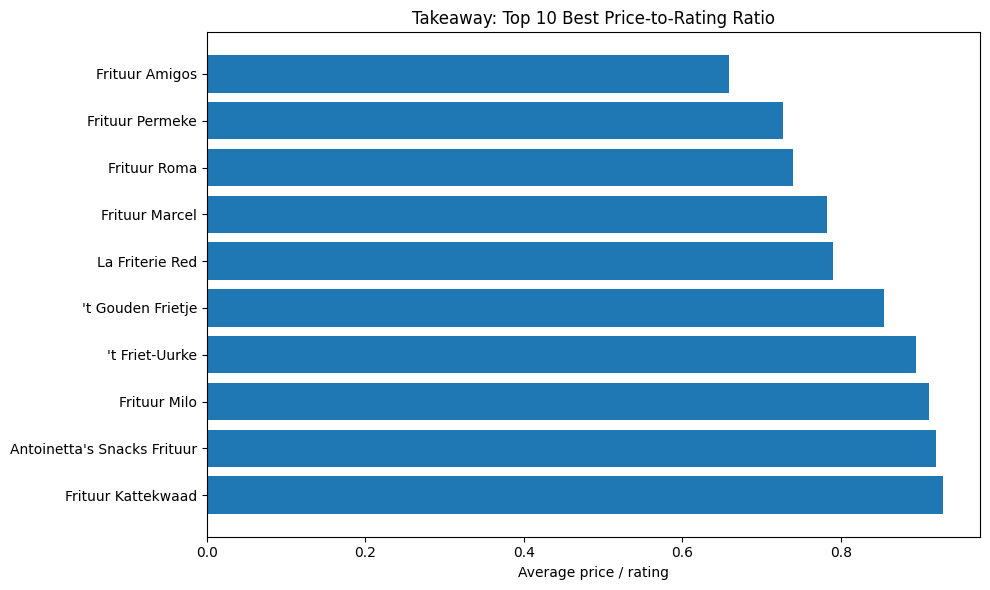

In [42]:
import matplotlib.pyplot as plt

df = ratio.copy().sort_values("price_to_ratio", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df["name"], df["price_to_ratio"])
plt.title("Takeaway: Top 10 Best Price-to-Rating Ratio")
plt.xlabel("Average price / rating")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Q7. How does the availability of vegetarian and vegan dishes vary by area

In [92]:
sql_query = """
SELECT
  r.city,
  COUNT(*) AS availability_count
FROM ta.restaurants r
JOIN ta.menuItems mi
  ON mi.primarySlug = r.primarySlug
WHERE mi.name IS NOT NULL
  AND (
    LOWER(mi.name) LIKE '%vegen%'
    OR LOWER(mi.name) LIKE '%vegetarisch%'
    OR LOWER(mi.name) LIKE '%veggie%'
  )
  AND r.city IS NOT NULL
  AND TRIM(r.city) <> ''
GROUP BY r.city
ORDER BY availability_count DESC
LIMIT 10;
"""

top_10_cities = q(conn, sql_query)
top_10_cities


city  availability_count
0       Gent                 607
1  Antwerpen                 586
2     Leuven                 289
3   Mechelen                 150
4     Brugge                 150
5   Oostende                 132
6    Hasselt                  98
7      Aalst                  96
8     Deurne                  93
9    Merksem                  78

In [94]:
import folium
from branca.colormap import linear
from folium.plugins import MarkerCluster
from pathlib import Path
import webbrowser

veggie_restaurants_sql = """
SELECT
  r.primarySlug AS restaurant_key,
  r.name AS name,
  CAST(r.latitude AS REAL)  AS latitude,
  CAST(r.longitude AS REAL) AS longitude,
  r.address AS address,
  r.city AS city,
  COUNT(*) AS veg_item_count
FROM ta.restaurants r
JOIN ta.menuItems mi
  ON mi.primarySlug = r.primarySlug
WHERE r.latitude IS NOT NULL
  AND r.longitude IS NOT NULL
  AND mi.name IS NOT NULL
  AND (
    -- English
    LOWER(mi.name) LIKE '%vegetarian%'
    OR LOWER(mi.name) LIKE '%vegan%'
    OR LOWER(mi.name) LIKE '%veggie%'
    OR LOWER(mi.name) LIKE '%plant based%'
    OR LOWER(mi.name) LIKE '%plant-based%'
    OR LOWER(mi.name) LIKE '%plant%'

    -- French
    OR LOWER(mi.name) LIKE '%vegetarien%'
    OR LOWER(mi.name) LIKE '%végétarien%'
    OR LOWER(mi.name) LIKE '%végé%'
    OR LOWER(mi.name) LIKE '%vege%'
    OR LOWER(mi.name) LIKE '%vegetal%'
    OR LOWER(mi.name) LIKE '%végétal%'
    OR LOWER(mi.name) LIKE '%base de plantes%'
    OR LOWER(mi.name) LIKE '%base végétale%'
    OR LOWER(mi.name) LIKE '%plantes%'

    -- Flemish/Dutch
    OR LOWER(mi.name) LIKE '%vegetarisch%'
    OR LOWER(mi.name) LIKE '%plantaardig%'
    OR LOWER(mi.name) LIKE '%op basis van planten%'
    OR LOWER(mi.name) LIKE '%100% plantaardig%'
  )
GROUP BY r.primarySlug, r.name, r.latitude, r.longitude, r.address, r.city
ORDER BY veg_item_count DESC;
"""

df = q(conn, veggie_restaurants_sql).dropna(subset=["latitude", "longitude", "veg_item_count"]).copy()

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

if not df.empty:
    vmin = float(df["veg_item_count"].min())
    vmax = float(df["veg_item_count"].max())

    colormap = linear.Greens_09.scale(vmin, vmax)
    colormap.caption = "Veg/Vegan/Plant-based item count (per restaurant)"
    colormap.add_to(m)

    cluster = MarkerCluster().add_to(m)

    for _, row in df.iterrows():
        popup = (
            f"Name: {row['name']}<br>"
            f"City: {row.get('city','')}<br>"
            f"Veg items: {int(row['veg_item_count'])}<br>"
            f"Address: {row.get('address','')}"
        )

        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=6,
            color=colormap(row["veg_item_count"]),
            fill=True,
            fill_color=colormap(row["veg_item_count"]),
            fill_opacity=0.8,
            popup=folium.Popup(popup, max_width=300),
        ).add_to(cluster)

out_path = Path(r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway_veggie_restaurants_map.html").resolve()
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway_veggie_restaurants_map.html


# The World Hummus Order (WHO); top 3 hummus serving restaurants.

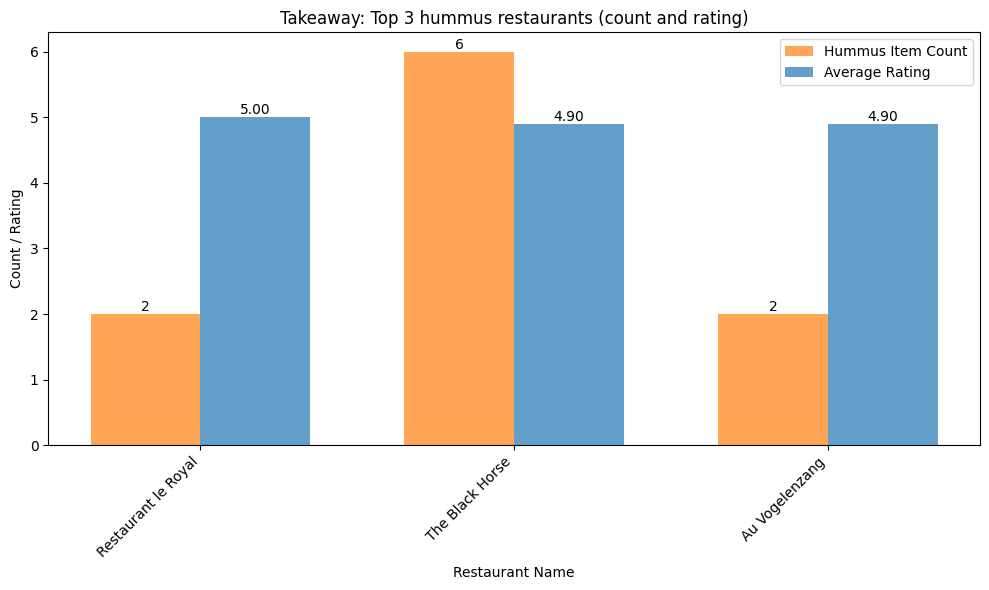

restaurant_name  avg_rating  hummus_item_count
0  Restaurant le Royal         5.0                  2
1      The Black Horse         4.9                  6
2       Au Vogelenzang         4.9                  2

In [61]:
import matplotlib.pyplot as plt

takeaway_hummus_sql = """
SELECT
  r.name AS restaurant_name,
  CAST(r.ratings AS REAL) AS avg_rating,
  COUNT(*) AS hummus_item_count
FROM ta.restaurants r
JOIN ta.menuItems mi
  ON r.primarySlug = mi.primarySlug
WHERE mi.name IS NOT NULL
  AND (
    LOWER(mi.name) LIKE '%hummus%'
    OR LOWER(mi.name) LIKE '%houmous%'
    OR LOWER(mi.name) LIKE '%homous%'
    OR LOWER(mi.name) LIKE '%houmos%'
  )
  AND r.ratingsNumber IS NOT NULL
  AND CAST(r.ratingsNumber AS INT) > 100
  AND r.ratings IS NOT NULL
GROUP BY r.primarySlug, r.name, r.ratings
ORDER BY avg_rating DESC, hummus_item_count DESC
LIMIT 3;
"""

df = q(conn, takeaway_hummus_sql)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(df))

bars1 = ax.bar(
    index,
    df["hummus_item_count"],
    bar_width,
    label="Hummus Item Count",
    color="tab:orange",
    alpha=0.7
)

bars2 = ax.bar(
    [i + bar_width for i in index],
    df["avg_rating"],
    bar_width,
    label="Average Rating",
    color="tab:blue",
    alpha=0.7
)

ax.set_xlabel("Restaurant Name")
ax.set_ylabel("Count / Rating")
ax.set_title("Takeaway: Top 3 hummus restaurants (count and rating)")
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df["restaurant_name"], rotation=45, ha="right")
ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", ha="center", va="bottom")

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

df


# Create a Venn diagram comparing restaurant distributions across all platforms

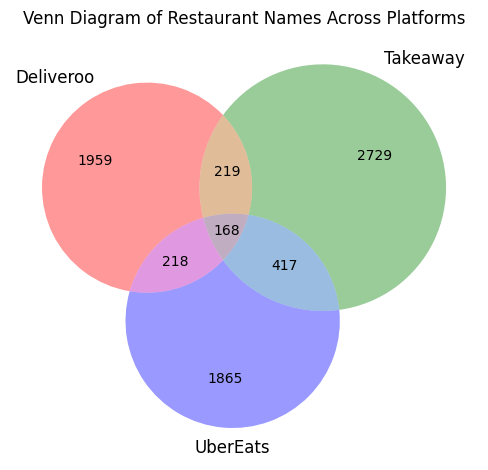

In [23]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Distinct restaurant names from each platform (your setup: main=Deliveroo, ta=Takeaway, ue=UberEats)
ids1 = set(q(conn, "SELECT DISTINCT name  FROM restaurants     WHERE name  IS NOT NULL;")["name"])
ids2 = set(q(conn, "SELECT DISTINCT name  FROM ta.restaurants  WHERE name  IS NOT NULL;")["name"])
ids3 = set(q(conn, "SELECT DISTINCT title FROM ue.restaurants  WHERE title IS NOT NULL;")["title"])

only_in_1 = ids1 - ids2 - ids3
only_in_2 = ids2 - ids1 - ids3
only_in_3 = ids3 - ids1 - ids2

in_1_and_2 = (ids1 & ids2) - ids3
in_1_and_3 = (ids1 & ids3) - ids2
in_2_and_3 = (ids2 & ids3) - ids1

in_all = ids1 & ids2 & ids3

venn3(
    subsets=(
        len(only_in_1),
        len(only_in_2),
        len(in_1_and_2),
        len(only_in_3),
        len(in_1_and_3),
        len(in_2_and_3),
        len(in_all),
    ),
    set_labels=("Deliveroo", "Takeaway", "UberEats"),
)

plt.title("Venn Diagram of Restaurant Names Across Platforms")
plt.tight_layout()
plt.show()
